<a href="https://colab.research.google.com/github/DVBharath2005/Major-Project/blob/main/Hotel_Booking_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Booking Windows ---
Lead time quantiles: {'q10': 3.0, 'q25': 18.0, 'q50': 69.0, 'q75': 160.0, 'q90': 265.0}

Lead time by hotel:
hotel
City Hotel      74.0
Resort Hotel    57.0
Name: lead_time, dtype: float64


/tmp/ipython-input-3767453484.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lt_by_month = df.groupby("arrival_date_month")["lead_time"].median()


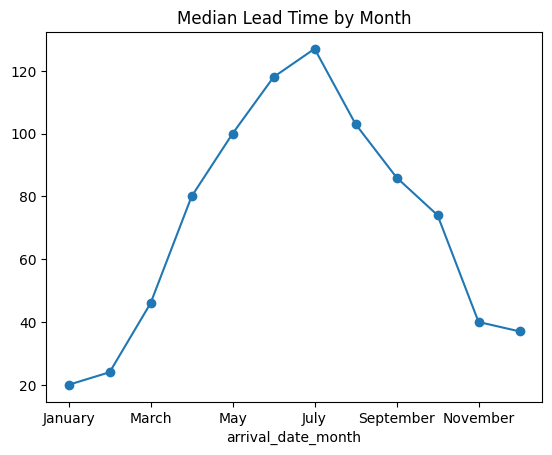


--- Length of Stay vs ADR ---
Correlation LOS vs ADR: 0.01964115416929074


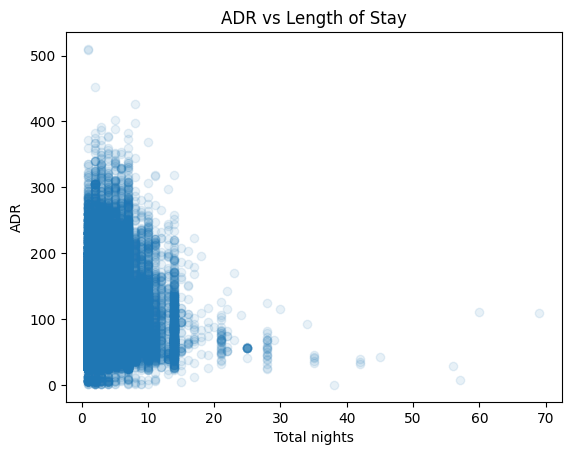


--- Special Requests ---


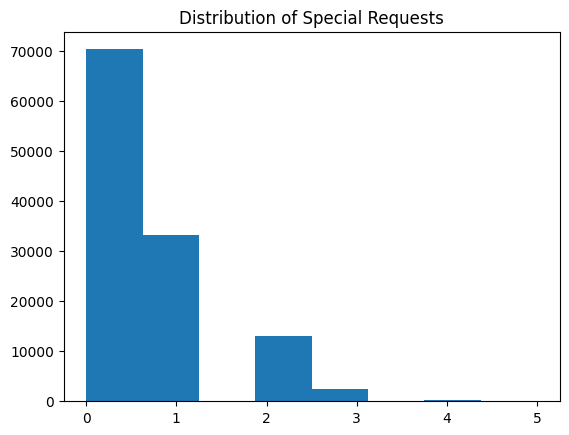

Top drivers:
 party_size           0.406506
arrival_month_num    0.222837
total_nights         0.191590
weekend_share        0.141252
has_kids             0.037816
dtype: float64

--- Demographics ---
Party size quantiles: {'q10': 1.0, 'q25': 2.0, 'q50': 2.0, 'q75': 2.0, 'q90': 3.0}
Rate with children: 0.07194907446184773
Rate with babies: 0.00768071027724265

Market segments:
 market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Name: count, dtype: int64

Top countries:
 country
PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
ITA     3766
IRL     3375
BEL     2342
BRA     2224
NLD     2104
Name: count, dtype: int64

--- Prime Booking Windows ---
lead_bucket
0-3d         85.00
4-7d         88.00
8-14d        95.00
15-30d       96.28
31-60d       94.00
61-90d       96.30
91-180d      99.00
181-365d     90.95
>365d       112.67
Name: adr, dtype: float64


/tmp/ipython-input-3767453484.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["lead_bucket"] = pd.cut(d["lead_time"], bins=bins, labels=labels)
/tmp/ipython-input-3767453484.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = d.groupby("lead_bucket")["adr"].median()


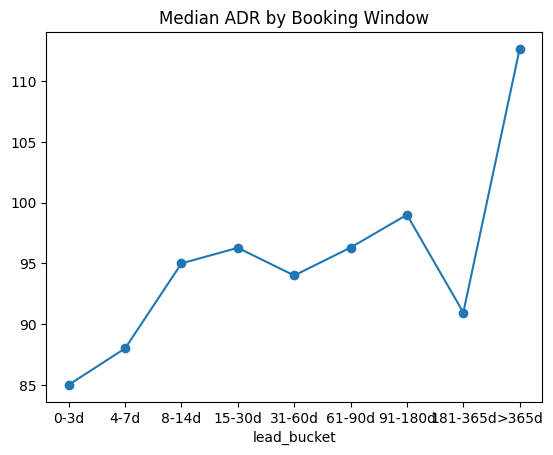

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

# ========== CONFIG ==========
CSV_PATH = "Hotel Bookings.csv"   # <-- place your dataset here
month_order = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]

# ========== CLEANING ==========
def clean_dataframe(df):
    df = df.copy()

    numeric_cols = [
        "lead_time", "stays_in_weekend_nights", "stays_in_week_nights",
        "adults", "children", "babies", "adr",
        "previous_cancellations", "previous_bookings_not_canceled",
        "booking_changes", "required_car_parking_spaces",
        "total_of_special_requests"
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Fill missing children/babies
    for c in ["children", "babies"]:
        if c in df.columns:
            df[c] = df[c].fillna(0)

    # Derived columns
    if {"stays_in_weekend_nights","stays_in_week_nights"}.issubset(df.columns):
        df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

    if "total_nights" in df.columns and "stays_in_weekend_nights" in df.columns:
        df["weekend_share"] = np.where(df["total_nights"]>0,
                                       df["stays_in_weekend_nights"]/df["total_nights"],0)

    if {"adults","children","babies"}.issubset(df.columns):
        df["party_size"] = df[["adults","children","babies"]].sum(axis=1)
        df["has_kids"] = ((df["children"]>0)|(df["babies"]>0)).astype(int)

    # arrival month numeric
    if {"arrival_date_year","arrival_date_month"}.issubset(df.columns):
        month_to_num = {m:i+1 for i,m in enumerate(month_order)}
        df["arrival_month_num"] = df["arrival_date_month"].map(month_to_num)

    if "is_canceled" in df.columns:
        df["is_canceled"] = pd.to_numeric(df["is_canceled"], errors="coerce").fillna(0).astype(int)

    return df

# ========== HELPERS ==========
def safe_quantiles(s, qs=[0.1,0.25,0.5,0.75,0.9]):
    s = s.dropna().astype(float)
    return {f"q{int(q*100)}": round(v,2) for q,v in s.quantile(qs).items()} if len(s)>0 else {}

# ========== ANALYSIS ==========
def analyze_booking_windows(df):
    print("\n--- Booking Windows ---")
    print("Lead time quantiles:", safe_quantiles(df["lead_time"]))

    # by hotel
    if {"hotel","lead_time"}.issubset(df.columns):
        print("\nLead time by hotel:")
        print(df.groupby("hotel")["lead_time"].median())

    # by month
    if {"arrival_date_month","lead_time"}.issubset(df.columns):
        cat_type = pd.CategoricalDtype(categories=month_order, ordered=True)
        df["arrival_date_month"] = df["arrival_date_month"].astype(cat_type)
        lt_by_month = df.groupby("arrival_date_month")["lead_time"].median()
        lt_by_month.plot(marker="o",title="Median Lead Time by Month")
        plt.show()

def analyze_los_vs_adr(df):
    print("\n--- Length of Stay vs ADR ---")
    d = df[(df["is_canceled"]==0)&(df["adr"]>0)&(df["total_nights"]>0)]
    print("Correlation LOS vs ADR:", d["total_nights"].corr(d["adr"]))

    plt.scatter(d["total_nights"], d["adr"], alpha=0.1)
    plt.title("ADR vs Length of Stay")
    plt.xlabel("Total nights"); plt.ylabel("ADR")
    plt.show()

def analyze_special_requests(df):
    print("\n--- Special Requests ---")
    y = df["total_of_special_requests"]
    plt.hist(y, bins=8)
    plt.title("Distribution of Special Requests")
    plt.show()

    # optional feature importance if sklearn is installed
    try:
        from sklearn.ensemble import RandomForestRegressor
        X = df[["total_nights","weekend_share","party_size","has_kids","arrival_month_num"]].fillna(0)
        model = RandomForestRegressor(n_estimators=200,random_state=0)
        model.fit(X,y)
        imp = pd.Series(model.feature_importances_, index=X.columns)
        print("Top drivers:\n", imp.sort_values(ascending=False))
    except:
        print("Install scikit-learn for feature importance.")

def analyze_demographics(df):
    print("\n--- Demographics ---")
    print("Party size quantiles:", safe_quantiles(df["party_size"]))
    print("Rate with children:", (df["children"]>0).mean())
    print("Rate with babies:", (df["babies"]>0).mean())

    if "market_segment" in df.columns:
        print("\nMarket segments:\n", df["market_segment"].value_counts().head())

    if "country" in df.columns:
        print("\nTop countries:\n", df["country"].value_counts().head(10))

def prime_time_by_price(df):
    print("\n--- Prime Booking Windows ---")
    d = df[(df["is_canceled"]==0)&(df["adr"]>0)]
    bins = [-1,3,7,14,30,60,90,180,365,10000]
    labels = ["0-3d","4-7d","8-14d","15-30d","31-60d","61-90d","91-180d","181-365d",">365d"]
    d["lead_bucket"] = pd.cut(d["lead_time"], bins=bins, labels=labels)
    summary = d.groupby("lead_bucket")["adr"].median()
    print(summary)

    summary.plot(marker="o",title="Median ADR by Booking Window")
    plt.show()

# ========== MAIN ==========
if not os.path.exists(CSV_PATH):
    print(f"Dataset {CSV_PATH} not found. Please place your CSV in this path.")
else:
    df = pd.read_csv(CSV_PATH)
    df = clean_dataframe(df)

    analyze_booking_windows(df)
    analyze_los_vs_adr(df)
    analyze_special_requests(df)
    analyze_demographics(df)
    prime_time_by_price(df)
